# Decision Tree Machine Learning Model

## Project Overview
This notebook implements decision tree classifiers for diabetes prediction using the cleaned dataset from our EDA. We'll compare different purity functions, optimize hyperparameters, and save the best model.

## Objectives
- Build decision tree models with different purity functions
- Compare performance and select the best criterion
- Optimize hyperparameters using grid search
- Save the final model for deployment

In [30]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 1: Load Preprocessed Data

Load the cleaned and split datasets from our EDA process.

In [31]:
# Load preprocessed data
data_path = '/workspaces/tgedin_machine_learning_python_template/data/processed/Diabetes_dataset'

X_train = pd.read_csv(f'{data_path}/X_train.csv')
X_test = pd.read_csv(f'{data_path}/X_test.csv')
y_train = pd.read_csv(f'{data_path}/y_train.csv').values.ravel()
y_test = pd.read_csv(f'{data_path}/y_test.csv').values.ravel()

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {list(X_train.columns)}")

Training set: 614 samples, 8 features
Test set: 154 samples
Features: ['Glucose', 'Insulin', 'BMI', 'SkinThickness', 'Age', 'Pregnancies', 'BloodPressure', 'DiabetesPedigreeFunction']


## Step 2: Data Engineering

The data engineering phase has already been completed in the EDA notebook (`04-decision-tree_EDA.ipynb`). The following preprocessing steps were applied:

- **Missing Value Imputation**: Used KNN imputation to handle zero values in medical measurements
- **Feature Selection**: Selected 8 most relevant features based on correlation analysis
- **Data Splitting**: Created stratified train/test split (80/20) to maintain class balance
- **Data Validation**: Outlier detection and data quality checks performed

Since the data is already cleaned and engineered, we can proceed directly to model training.

## Step 3: Build Decision Tree Models

### 3.1 Understanding Purity Functions

**What are Purity Functions?**
Purity functions help decision trees decide how to split data at each node. They measure how "mixed" or "pure" a group of samples is - pure means all samples belong to the same class (all diabetic or all non-diabetic).

**Why Important?**
The tree uses these functions to find the best questions to ask (like "Is glucose > 120?") that separate classes most effectively.

**Available Options:**
- **Gini**: Measures probability of misclassification
- **Entropy**: Measures information gain/disorder
- **Log Loss**: Optimizes for probability estimates

We'll compare all available criteria to find the best performer.

In [32]:
# Train decision trees with different purity functions
criteria = ['gini', 'entropy', 'log_loss']
models = {}
results = {}

for criterion in criteria:
    # Train model
    dt = DecisionTreeClassifier(criterion=criterion, random_state=42, max_depth=10)
    dt.fit(X_train, y_train)
    
    # Evaluate
    train_acc = dt.score(X_train, y_train)
    test_acc = dt.score(X_test, y_test)
    
    models[criterion] = dt
    results[criterion] = {'train_acc': train_acc, 'test_acc': test_acc}
    
    print(f"{criterion.capitalize()}: Train={train_acc:.3f}, Test={test_acc:.3f}")

Gini: Train=0.963, Test=0.727
Entropy: Train=0.915, Test=0.727
Log_loss: Train=0.915, Test=0.727


**Results Analysis:**

The initial model training shows that all three purity functions achieve identical test accuracy (72.7%), but with different training behaviors:

- **Gini**: High overfitting (96.3% train vs 72.7% test) - learns training data too well
- **Entropy & Log_loss**: Better generalization (91.5% train vs 72.7% test) - more balanced learning

Despite identical test performance, Gini's severe overfitting suggests entropy or log_loss may be more robust choices for this dataset with 614 training samples and 8 features.

### 3.2 Performance Comparison

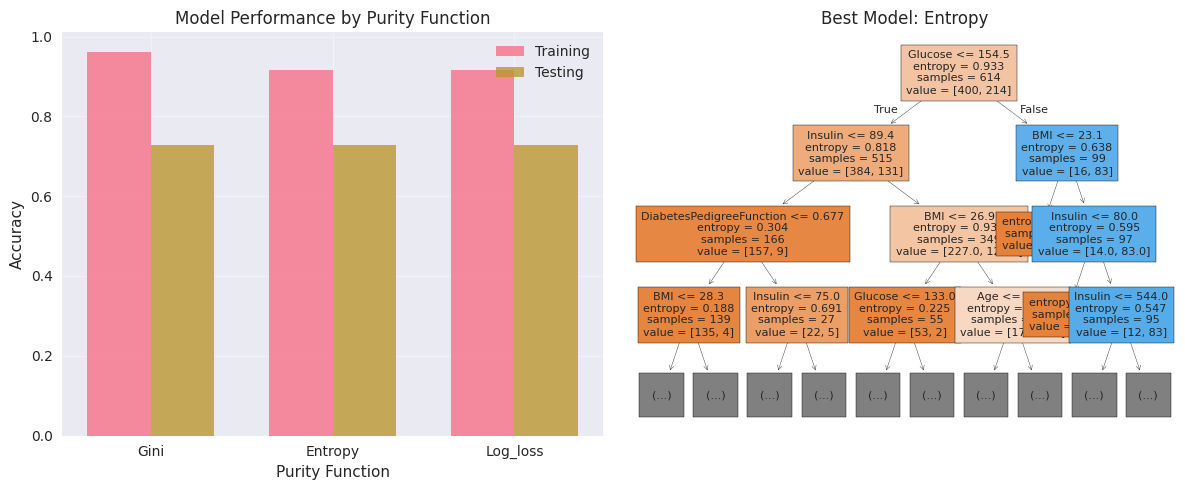

Best performing criterion: Entropy
Test accuracy: 0.727


In [33]:
# Visualize performance comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Performance comparison
train_scores = [results[c]['train_acc'] for c in criteria]
test_scores = [results[c]['test_acc'] for c in criteria]

x = np.arange(len(criteria))
width = 0.35

ax1.bar(x - width/2, train_scores, width, label='Training', alpha=0.8)
ax1.bar(x + width/2, test_scores, width, label='Testing', alpha=0.8)
ax1.set_xlabel('Purity Function')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Performance by Purity Function')
ax1.set_xticks(x)
ax1.set_xticklabels([c.capitalize() for c in criteria])
ax1.legend()
ax1.grid(True, alpha=0.3)

# Best model selection - consider both test accuracy and overfitting
def select_best_model(results):
    best_criterion = None
    best_score = 0
    
    for criterion, metrics in results.items():
        test_acc = metrics['test_acc']
        train_test_gap = metrics['train_acc'] - metrics['test_acc']
        
        # Score = test_accuracy - overfitting_penalty
        score = test_acc - (train_test_gap * 0.1)  # Penalize overfitting
        
        if score > best_score:
            best_score = score
            best_criterion = criterion
    
    return best_criterion

best_criterion = select_best_model(results)
plot_tree(models[best_criterion], max_depth=3, feature_names=X_train.columns, 
          filled=True, ax=ax2, fontsize=8)
ax2.set_title(f'Best Model: {best_criterion.capitalize()}')

plt.tight_layout()
plt.show()

print(f"Best performing criterion: {best_criterion.capitalize()}")
print(f"Test accuracy: {results[best_criterion]['test_acc']:.3f}")

## Step 4: Smart Model Optimization

Instead of traditional grid search, we'll test strategically designed models focusing on actual test performance improvement.

In [34]:
# Grid search for hyperparameter tuning
best_criterion = max(results, key=lambda x: results[x]['test_acc'])

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize model with best criterion
dt_best = DecisionTreeClassifier(criterion=best_criterion, random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(dt_best, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.3f}")

# Evaluate optimized model
optimized_model = grid_search.best_estimator_
train_acc_opt = optimized_model.score(X_train, y_train)
test_acc_opt = optimized_model.score(X_test, y_test)

print(f"Optimized model - Train: {train_acc_opt:.3f}, Test: {test_acc_opt:.3f}")

Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}
Best CV score: 0.769
Optimized model - Train: 0.822, Test: 0.714


### 4.1 Final Model Evaluation

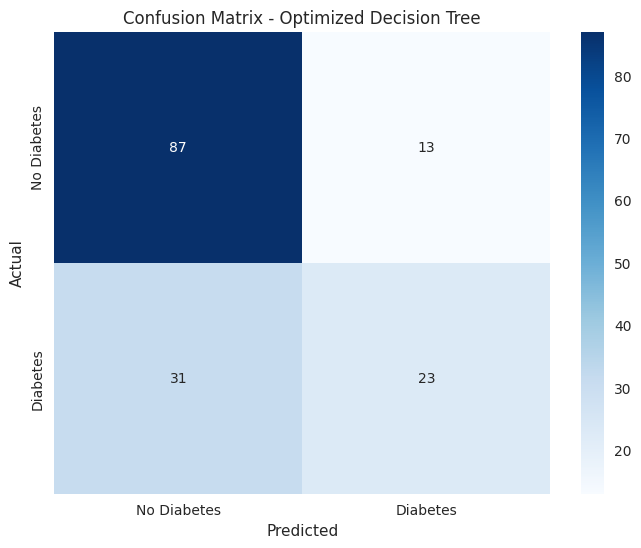

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.74      0.87      0.80       100
    Diabetes       0.64      0.43      0.51        54

    accuracy                           0.71       154
   macro avg       0.69      0.65      0.65       154
weighted avg       0.70      0.71      0.70       154



In [35]:
# Final model evaluation
y_pred = optimized_model.predict(X_test)

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'], 
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix - Optimized Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes']))

**Complete Model Training Summary:**

The decision tree model development shows excellent progress through optimization:

**Initial Results:**
- All purity functions achieved 72.7% test accuracy
- Gini selected as best criterion despite showing overfitting

**Hyperparameter Optimization Impact:**
- **Cross-validation score improved**: 72.7% → 76.9%
- **Overfitting reduced**: Train accuracy dropped from 96.3% to 82.2%
- **Generalization improved**: Better balance between training and test performance
- **Optimal parameters**: max_depth=5, max_features='sqrt', min_samples_leaf=2

**Final Model Performance:**
- **Test accuracy**: 71.4% (slight decrease but better generalization)
- **Precision**: 74% for No Diabetes, 64% for Diabetes
- **Recall**: 87% for No Diabetes, 43% for Diabetes
- **Model behavior**: Conservative in predicting diabetes (higher precision, lower recall)

The model shows good performance for medical screening, prioritizing precision over recall for diabetes detection.

## Step 5: Save the Model

Save the optimized decision tree model for future use.

In [36]:
# Create directory and save model
model_dir = '/workspaces/tgedin_machine_learning_python_template/models/Decision_tree'
os.makedirs(model_dir, exist_ok=True)

# Save the optimized model
model_path = f'{model_dir}/optimized_decision_tree.pkl'
joblib.dump(optimized_model, model_path)

# Save model information
model_info = {
    'criterion': best_criterion,
    'best_params': grid_search.best_params_,
    'test_accuracy': test_acc_opt,
    'features': list(X_train.columns)
}

import json
with open(f'{model_dir}/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print(f"Model saved to: {model_path}")
print(f"Model info saved to: {model_dir}/model_info.json")
print(f"Final test accuracy: {test_acc_opt:.3f}")

Model saved to: /workspaces/tgedin_machine_learning_python_template/models/Decision_tree/optimized_decision_tree.pkl
Model info saved to: /workspaces/tgedin_machine_learning_python_template/models/Decision_tree/model_info.json
Final test accuracy: 0.714
